In [ ]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr

# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the data
fatigue_df = pd.read_csv('../Data/Carbon_Bending_PI.csv')
fatigue_df

# Removing rows with null values
fatigue_df = fatigue_df.dropna()

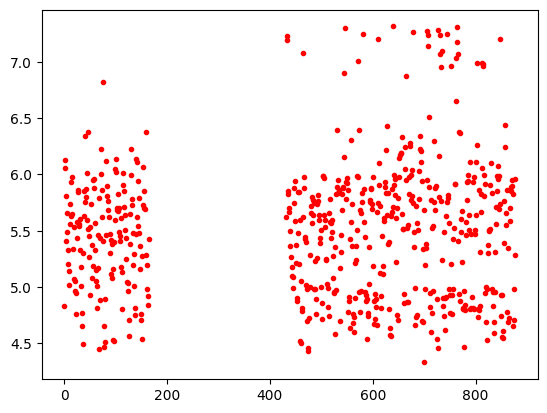

In [ ]:
# Scatter Plot
plt.plot(np.log10(fatigue_df['Number of Cycles']), 'r.')

# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

In [ ]:
drop_cols = ['Heat','Number of Cycles','Dataset'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (Mpa),Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu,PI Fatigue Life
0,460,650,1270,0.04,0.01,0.00,50.0,29,70,0.42,0.26,0.70,0.024,0.010,0.01,0.01,0.01,2.485278e+04
1,500,550,825,0.11,0.04,0.00,50.0,23,67,0.42,0.22,0.78,0.022,0.020,0.01,0.02,0.03,1.760709e+04
2,470,550,825,0.08,0.00,0.00,50.0,22,68,0.33,0.21,0.75,0.031,0.019,0.01,0.03,0.02,2.601282e+04
3,580,550,825,0.10,0.00,0.00,50.0,22,60,0.54,0.20,0.75,0.013,0.019,0.01,0.01,0.01,1.366745e+04
4,480,550,825,0.11,0.04,0.00,50.0,23,67,0.42,0.22,0.78,0.022,0.020,0.01,0.02,0.03,4.867573e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,520,550,1270,0.08,0.01,0.00,50.0,19,58,0.54,0.26,0.76,0.022,0.021,0.02,0.12,0.01,1.027129e+07
607,480,550,825,0.10,0.00,0.00,50.0,22,60,0.54,0.20,0.75,0.013,0.019,0.01,0.01,0.01,6.859817e+06
608,450,600,1740,0.07,0.00,0.00,50.0,22,64,0.45,0.25,0.79,0.018,0.016,0.02,0.13,0.13,1.484439e+07
609,530,550,610,0.08,0.00,0.04,50.0,16,50,0.54,0.27,0.70,0.017,0.020,0.06,0.10,0.22,1.304105e+07


In [ ]:
# Convert the features into floats
features = features.astype('float64')

In [ ]:
!pip install pyro-ppl

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS

class BNN(PyroModule):
    def __init__(self, in_dim=18, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        # x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

# Coverage
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 4.0 MB/s eta 0:00:00


Run # 1 Fold # 1


Sample: 100%|██████████| 200/200 [26:50,  8.05s/it, step size=1.81e-03, acc. prob=0.964]


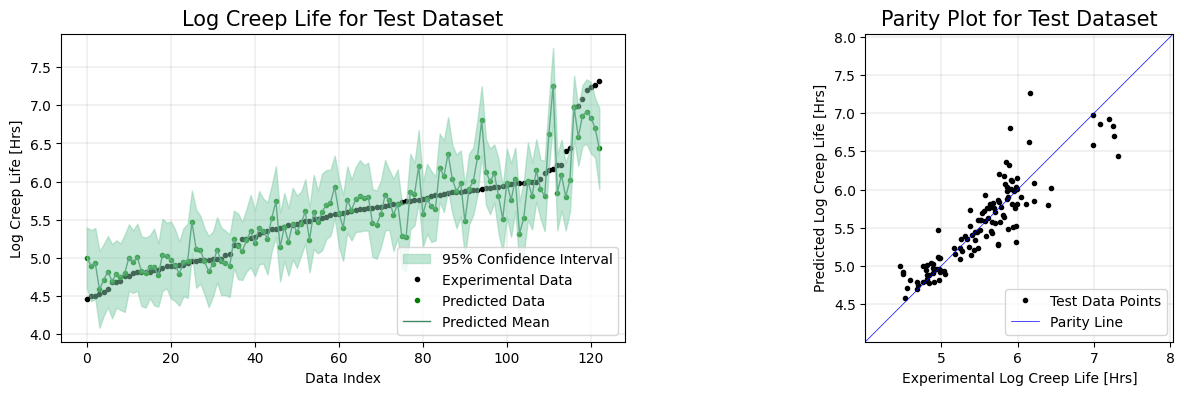

Pearson CC: 0.8937990020158776
R2 score: 0.7976093976883931
RMSE: 0.27638146554117954
MAE: 0.19625943076528912
MAPE: 0.034481706344133244
Coverage: 87.80487804878045
Upper coverage: 95.12195121951216
Lower coverage: 92.68292682926825
Average Interval Width: 0.8919317722320557
Median Interval Width: 0.8874759674072266
Composite Metric: 0.9402343542985475
********************
Run # 1 Fold # 2


Sample: 100%|██████████| 200/200 [26:49,  8.05s/it, step size=1.66e-03, acc. prob=0.971]


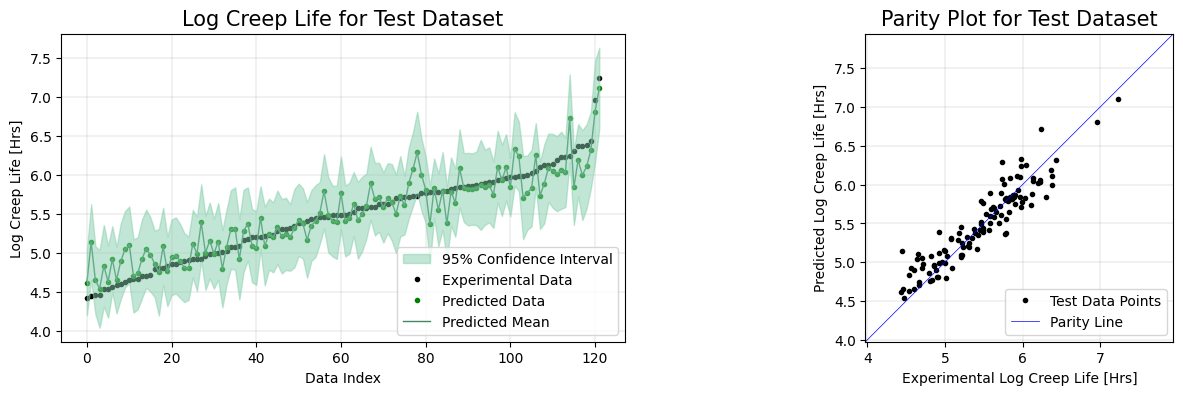

Pearson CC: 0.9298895142867337
R2 score: 0.8607318049513447
RMSE: 0.20956829312541198
MAE: 0.16113554609757302
MAPE: 0.029939640622810022
Coverage: 98.36065573770496
Upper coverage: 98.36065573770496
Lower coverage: 100.00000000000004
Average Interval Width: 0.9409449696540833
Median Interval Width: 0.9418621063232422
Composite Metric: 1.003136554279337
********************
Run # 1 Fold # 3


Sample: 100%|██████████| 200/200 [27:22,  8.21s/it, step size=1.56e-03, acc. prob=0.969]


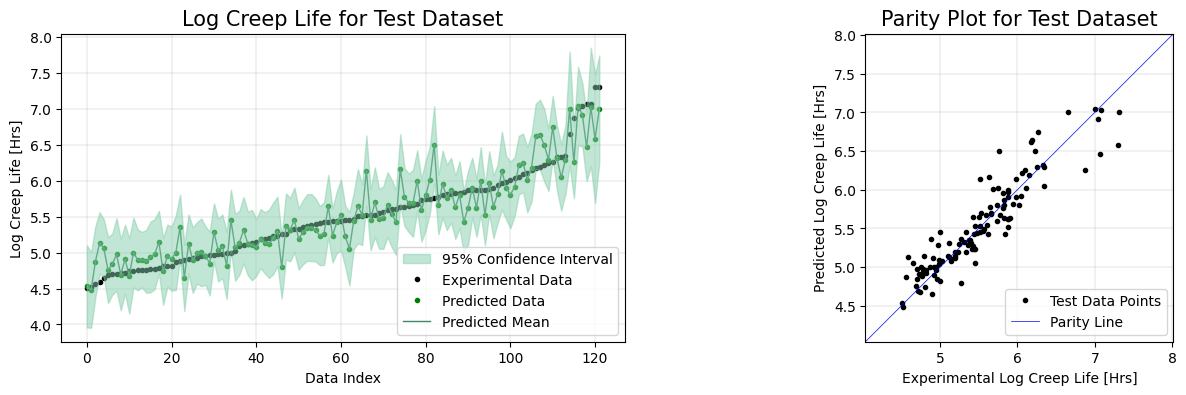

Pearson CC: 0.924687617070235
R2 score: 0.852513050414325
RMSE: 0.24138227836084744
MAE: 0.17673231056796973
MAPE: 0.031867368070183984
Coverage: 90.98360655737709
Upper coverage: 93.44262295081971
Lower coverage: 97.54098360655742
Average Interval Width: 0.9305536150932312
Median Interval Width: 0.9013051986694336
Composite Metric: 0.9597525712222142
********************
Run # 1 Fold # 4


Sample: 100%|██████████| 200/200 [27:16,  8.18s/it, step size=2.45e-03, acc. prob=0.912]


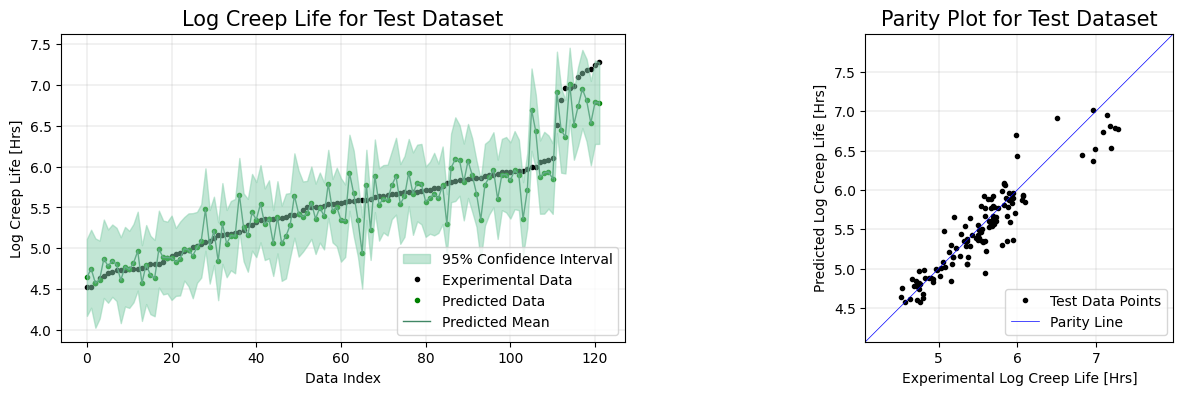

Pearson CC: 0.9288784201613072
R2 score: 0.8575858376418625
RMSE: 0.23584240174224508
MAE: 0.17241085778265758
MAPE: 0.02996592749475747
Coverage: 90.98360655737709
Upper coverage: 98.36065573770496
Lower coverage: 92.62295081967217
Average Interval Width: 0.9201633334159851
Median Interval Width: 0.9104518890380859
Composite Metric: 0.9569659681666252
********************
Run # 1 Fold # 5


Sample: 100%|██████████| 200/200 [27:28,  8.24s/it, step size=2.74e-03, acc. prob=0.906]


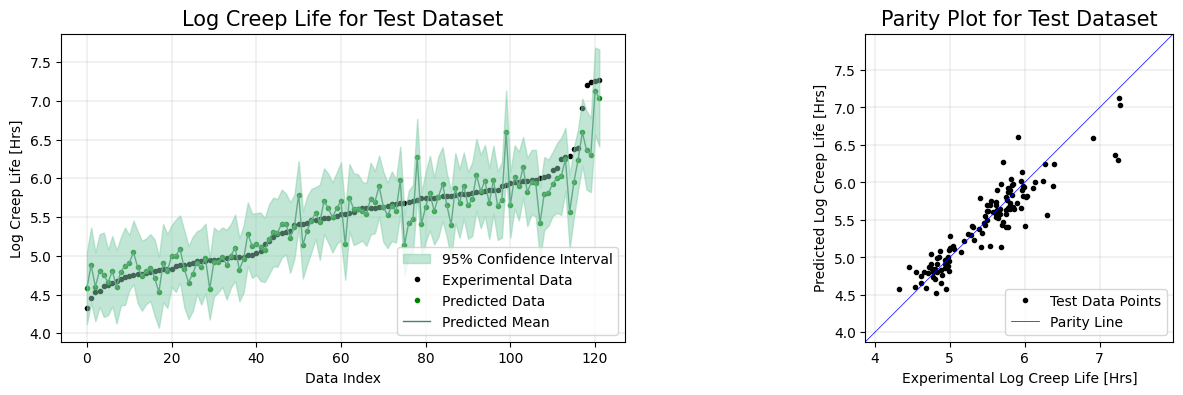

Pearson CC: 0.920207772621309
R2 score: 0.8427715871469913
RMSE: 0.237390585979431
MAE: 0.16760244249226486
MAPE: 0.02985564831056718
Coverage: 94.26229508196725
Upper coverage: 98.36065573770496
Lower coverage: 95.90163934426234
Average Interval Width: 0.8898527026176453
Median Interval Width: 0.8853740692138672
Composite Metric: 0.9893337389629505
********************


In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=50+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            # define DNN
            model = BNN(hid_dim=10, n_hid_layers=3, prior_scale=1)
            nuts_kernel = NUTS(model, jit_compile=False)
            mcmc = MCMC(nuts_kernel, num_samples=100)
            mcmc.run(torch.Tensor(x_train), torch.Tensor(y_train.to_numpy()))

            # evaluate the model on test data
            predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
            preds = predictive(torch.Tensor(x_test))

            y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
            y_std = preds['obs'].T.detach().numpy().std(axis=1)

            ## Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')

            ## Parity Plot
            # find the boundaries of y_test and y_pred values
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            ax[1].plot(y_test, y_pred, 'ko', markersize=3, label="Test Data Points")
            ax[1].legend(loc=4, fontsize=10, frameon=False)
            ax[1].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            ax[1].legend(loc=4, fontsize=10, frameon=True)
            ax[1].set_xlabel("Experimental Log Creep Life [Hrs]", fontsize=10)
            ax[1].set_ylabel("Predicted Log Creep Life [Hrs]", fontsize=10)
            ax[1].set_title("Parity Plot for Test Dataset", fontsize=15)
            ax[1].grid(True, which='major', linestyle='-', linewidth='0.25')
            ax[1].set_xlim(bounds)
            ax[1].set_ylim(bounds)
            ax[1].set_aspect("equal", adjustable="box") # Square aspect ratio
            plt.show()

            ## Metrics for evaluating the predictive accuracy of the model
            PearsonCC[j, i] = pearsonr(y_test, np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))
            MAPE[j, i] = mean_absolute_percentage_error(y_test, y_pred)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            print(f'MAPE: {MAPE[j, i]}')

            ## Metrics for evaluating the uncertainty quantification of the model
            # Coverage
            df_test_low = y_pred - 2*y_std
            df_test_mean = y_pred
            df_test_high = y_pred + 2*y_std
            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)
            upper_coverage[j, i] = coverage(y_test, df_test_low, np.inf)
            lower_coverage[j, i] = coverage(y_test, -np.inf, df_test_high)
            print(f'Coverage: {test_coverage[j, i]}')
            print(f'Upper coverage: {upper_coverage[j, i]}')
            print(f'Lower coverage: {lower_coverage[j, i]}')

            # Prediction interval width
            mean_interval_width[j, i] = np.mean(df_test_high - df_test_low)
            print(f'Average Interval Width: {mean_interval_width[j, i]}')
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            print(20*'*')

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'MAPE': MAPE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,MAPE
0,0.893799,0.797609,0.276381,0.196259,0.034482
1,0.929890,0.860732,0.209568,0.161136,0.029940
2,0.924688,0.852513,0.241382,0.176732,0.031867
3,0.928878,0.857586,0.235842,0.172411,0.029966
4,0.920208,0.842772,0.237391,0.167602,0.029856


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
MAPE_mean = np.mean(MAPE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
MAPE_std = np.std(MAPE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'MAPE Mean': MAPE_mean, 'MAPE Std': MAPE_std,},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,MAPE Mean,MAPE Std
0,0.919492,0.013295,0.842242,0.023131,0.240113,0.021334,0.174828,0.011904,0.031222,0.001796


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Upper Coverage': upper_coverage.flatten(), 'Lower Coverage': lower_coverage.flatten(),
                    'Mean Interval Width': mean_interval_width.flatten(), 'Median Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Upper Coverage,Lower Coverage,Mean Interval Width,Median Interval Width,Composite Metric
0,87.804878,95.121951,92.682927,0.891932,0.887476,0.940234
1,98.360656,98.360656,100.000000,0.940945,0.941862,1.003137
2,90.983607,93.442623,97.540984,0.930554,0.901305,0.959753
3,90.983607,98.360656,92.622951,0.920163,0.910452,0.956966
4,94.262295,98.360656,95.901639,0.889853,0.885374,0.989334


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
upper_coverage_mean = np.mean(upper_coverage)
lower_coverage_mean = np.mean(lower_coverage)
mean_interval_width_mean = np.mean(mean_interval_width)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
upper_coverage_std = np.std(upper_coverage)
lower_coverage_std = np.std(lower_coverage)
mean_interval_width_std = np.std(mean_interval_width)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 'Upper Coverage Mean': upper_coverage_mean, 'Upper Coverage Std': upper_coverage_std,
                  'Lower Coverage Mean': lower_coverage_mean, 'Lower Coverage Std': lower_coverage_std,
                    'Mean Interval Width Mean': mean_interval_width_mean, 'Mean Interval Width Std':mean_interval_width_std,
                    'Median Interval Width Mean': median_interval_width_mean, 'Median Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Upper Coverage Mean,Upper Coverage Std,Lower Coverage Mean,Lower Coverage Std,Mean Interval Width Mean,Mean Interval Width Std,Median Interval Width Mean,Median Interval Width Std,Composite Metric Mean,Composite Metric Std
0,92.479008,3.580331,96.729308,2.067355,95.7497,2.845294,0.914689,0.020522,0.905294,0.020465,0.969885,0.022946
